In [1]:
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import warnings

import tensorflow as tf
from tensorflow.core.util import event_pb2

warnings.filterwarnings("ignore")

2025-02-18 01:47:51.986026: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 01:47:51.992690: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 01:47:52.004054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739843272.020070 3802086 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739843272.024824 3802086 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl-f2py"
RUNS_DIR = f"{BASE_DIR}/FLWR_Orchestrator/FLWR_Orchestrator/runs"
REF_RUNS_DIR = f"{BASE_DIR}/FLWR_Orchestrator_REF/FLWR_Orchestrator/runs"

EXP_ID = "2025-02-"

In [4]:
def retrieve_data(algo, ref=False):
    exp_id = EXP_ID
    if ref:
        tfrecord_paths = glob(
            f"{REF_RUNS_DIR}/{exp_id}*/*_{algo}_*/*"
        )  # {exp_id}_
    else:
        tfrecord_paths = glob(
            f"{RUNS_DIR}/{exp_id}*/*_{algo}_*/*"
        )  # {exp_id}_
    cntr = 0
    data = {}
    for tfrecord_path in tfrecord_paths:
        seed = int(tfrecord_path.split("/")[-2].split("__")[-2])
        data[seed] = []
        episodic_idx = 0
        serialized_events = tf.data.TFRecordDataset(tfrecord_path)
        try:
            for serialized_example in serialized_events:
                e = event_pb2.Event.FromString(serialized_example.numpy())
                for v in e.summary.value:
                    if (
                        v.HasField("simple_value")
                        and v.tag == "charts/episodic_return"
                    ):
                        episodic_idx += 1
                        data[seed].append(
                            {
                                "episode": episodic_idx,
                                "episodic_return": -v.simple_value,  # Negate here to simplify later processing
                            }
                        )
        except Exception as e:
            pass
        cntr += 1
    return data

In [5]:
algo = "ddpg"
runs = {algo: retrieve_data(algo)}
ref_runs = {algo: retrieve_data(algo, ref=True)}

2025-02-18 01:48:00.221663: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-02-18 01:48:00.274571: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-02-18 01:48:00.362544: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-18 01:48:00.460716: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-18 01:48:00.666619: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-18 01:48:01.082646: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
def retrieve_plot_data(data, algo):
    episode_data = {}
    for seed_records in data[algo].values():
        for record in seed_records:
            episode = record["episode"]
            if episode not in episode_data:
                episode_data[episode] = []
            episode_data[episode].append(record["episodic_return"])

    episodes = sorted(episode_data.keys())
    returns = [episode_data[ep] for ep in episodes]
    return episodes, returns

In [7]:
episodes, returns = retrieve_plot_data(runs, algo)
runs_df = pd.DataFrame(returns)
runs_df.index = episodes
runs_df.tail()

,0,1,2,3,4
95,7447.068359,3339.572998,3371.241699,2595.252441,8385.117188
96,7471.990234,3065.316162,5209.184082,2866.705811,8363.588867
97,7631.172852,3621.979248,2698.002686,2978.472412,8341.332031
98,7722.757324,3522.613037,2860.019287,2786.871094,8280.925781
99,7603.801270,3393.376221,2657.695068,3000.789307,8339.458008


In [8]:
episodes, returns = retrieve_plot_data(ref_runs, algo)
ref_runs_df = pd.DataFrame(returns)
ref_runs_df.index = episodes
ref_runs_df = ref_runs_df.dropna()
ref_runs_df.tail()

,0,1,2,3,4
95,11758.595703,3021.432617,2965.955811,3213.720703,9462.511719
96,11782.717773,3016.065430,2953.747070,3327.251953,9470.996094
97,11749.313477,2988.573486,2979.053711,4446.420410,9458.639648
98,11627.500977,2958.388672,2946.692383,2775.986572,9475.621094
99,11629.257812,2953.614014,2977.887939,3422.937500,9520.595703


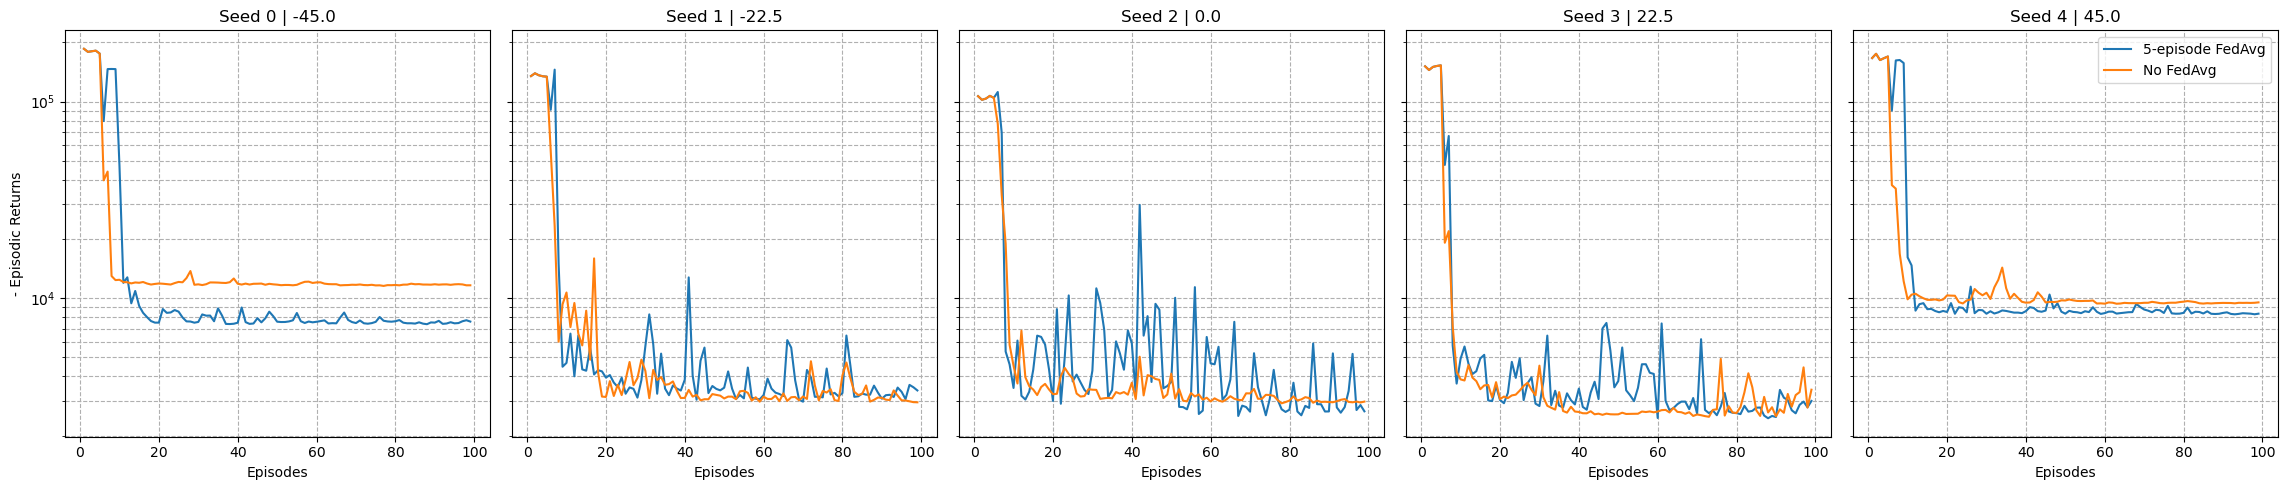

In [9]:
num_seeds = 5
fig, axes = plt.subplots(
    nrows=1, ncols=num_seeds, figsize=(23, 5), sharex=True, sharey=True
)

for seed in range(num_seeds):
    axes[seed].plot(runs_df[seed], label="5-episode FedAvg")
    axes[seed].plot(ref_runs_df[seed], label="No FedAvg")
    axes[seed].set_xlabel("Episodes")
    axes[seed].set_title(f"Seed {seed} | {-45 + 22.5*seed}")
    axes[seed].grid(True, which="both", ls="--")
    axes[seed].set_yscale("log")

axes[0].set_ylabel("- Episodic Returns")
axes[-1].legend()
plt.tight_layout()
plt.show()